
**OriVelt Limited**
-----
*Strategic Risk Assessment of Aircraft for New Aviation Operations*
-----


*1.1 Introduction*
------
OriVelt Limited is expanding into new industries so as to diversify its investment portfolio and one of the targeted sectors is aviation, particularly the purchase and operation of aircrafts for both commercial and private enterprices. Aviation is a high-profit, lucrative niche that is highly regulated and very risk intensive where substandard asset selection can result to substantial  financial losses, safety concerns and operational inefficiencies. 

This project aims at performing quantitative risk assessment on three areas; Damage Severity Risk and Geographic Risk. Fatality risk is modeled using reported loss-of-life outcomes to capture human and liability exposure, damage severity risk is assessed through encoded aircraft damage levels as a proxy for financial and asset loss, and geographic risk is analyzed using crash location characteristics that influence accident severity and emergency response effectiveness.

By integrating these risk dimensions, this project aims to identify aircraft types associated with lower overall risk profiles and provide evidence-based guidance to support strategic aircraft acquisition decisions for the company’s new aviation division.

*1.2 Data Understanding*
-----
The dataset consists of historical aircraft crash records containing Date, Aircraft Type, Registration, Operator, Fatalities (fat), Damage Severity (dmg), and Location. These variables support analysis of fatality risk, damage severity risk, and geographic risk by providing outcome-based, operational, temporal, and spatial information.

Several relevant variables are missing, including weather conditions, flight phase, aircraft age, maintenance history, and explicit terrain classification. Financial variables such as acquisition cost and insurance premiums are also unavailable; therefore, damage severity is used as a proxy for financial and asset loss. Location data varies in spatial precision, requiring geocoding and spatial inference for geographic analysis.

*1.3 Data Preparation*
-------
Data preparation focuses on cleaning, transforming, and engineering features to support fatality risk, damage severity risk, and geographic risk modeling. Aircraft type and operator fields are standardized to resolve naming inconsistencies and enable reliable grouping. Missing or ambiguous values in fatality counts and damage severity are handled through validation rules and, where appropriate, imputation or exclusion. Damage severity categories are encoded into ordinal numerical values to reflect increasing levels of asset loss.

In [1]:
import re #search, extract, and clean text automatically instead of doing it manually
import numpy as np
import pandas as pd

# Load dataset
df = pd.read_csv("flight.csv")

# Drop useless index column
df = df.drop(columns=["Unnamed: 0"])
df

,acc.date,type,reg,operator,fat,location,dmg
0,3 Jan 2022,British Aerospace 4121 Jetstream 41,ZS-NRJ,SA Airlink,0,near Venetia Mine Airport,sub
1,4 Jan 2022,British Aerospace 3101 Jetstream 31,HR-AYY,LANHSA - Línea Aérea Nacional de Honduras S.A,0,Roatán-Juan Manuel Gálvez International Airpor...,sub
2,5 Jan 2022,Boeing 737-4H6,EP-CAP,Caspian Airlines,0,Isfahan-Shahid Beheshti Airport (IFN),sub
3,8 Jan 2022,Tupolev Tu-204-100C,RA-64032,"Cainiao, opb Aviastar-TU",0,Hangzhou Xiaoshan International Airport (HGH),w/o
4,12 Jan 2022,Beechcraft 200 Super King Air,NaN,private,0,"Machakilha, Toledo District, Grahem Creek area",w/o
...,...,...,...,...,...,...,...
2495,20 Dec 2018,Cessna 560 Citation V,N188CW,Chen Aircrafts LLC,4,"2 km NE of Atlanta-Fulton County Airport, GA (...",w/o
2496,22 Dec 2018,PZL-Mielec M28 Skytruck,GNB-96107,Guardia Nacional Bolivariana de Venezuela - GNBV,0,Kamarata Airport (KTV),sub
2497,24 Dec 2018,Antonov An-26B,9T-TAB,Air Force of the Democratic Republic of the Congo,0,Beni Airport (BNC),w/o
2498,31 Dec 2018,Boeing 757-2B7 (WL),N938UW,American Airlines,0,"Charlotte-Douglas International Airport, NC (C...",sub


In [2]:
#standardize column names to avoid bugs 
df.columns = (
    df.columns
    .str.lower()
    .str.strip()
)


In [3]:
#Clean the Fatalities Column (fat)
df["fat"] = pd.to_numeric(df["fat"], errors="coerce")

# Replace missing fatalities with 0
df["fat"] = df["fat"].fillna(0).astype(int)
df["fat"]

0       0
1       0
2       0
3       0
4       0
       ..
2495    4
2496    0
2497    0
2498    0
2499    0
Name: fat, Length: 2500, dtype: int32

In [4]:
#Clean Text Fields (type, operator, location)
#To get rid of inconsistent captilaization, extra spaces 
text_cols = ["type", "operator", "location", "reg", "dmg"]

for col in text_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.lower()
        .str.strip()
    )

In [5]:
#Handle Missing Operators & Registrations
#We are working under the assumption that missing operators and registrations are unsafe
#This is to prevent data break

df["operator"] = df["operator"].replace("nan", "unknown")
df["reg"] = df["reg"].replace("nan", "unknown")

In [6]:
#Clean & Encode Damage Severity (dmg)
#We create a severity score for analysis's sak
#This is to allows mathematical risk comparison

dmg_map = {
    "minor": 1,
    "sub": 2,
    "w/o": 3
}

df["dmg_score"] = df["dmg"].map(dmg_map)

In [7]:
#Convert Accident Date (acc.date) to Datetime
#This is so as to enable trend analysis, seasonal checks and time-based sfetry improvements

df["acc.date"] = pd.to_datetime(df["acc.date"], errors="coerce")


In [8]:
#Final Data Quality Checks
# Check for remaining missing values
df.isna().sum()


acc.date       6
type           0
reg            0
operator       0
fat            0
location       0
dmg            0
dmg_score    468
dtype: int64

In [9]:
df["dmg"].value_counts()


sub    1330
w/o     702
non     338
min      98
unk      30
mis       2
Name: dmg, dtype: int64

In [10]:
assert df["dmg_score"].dropna().isin([1, 2, 3]).all(), \
       "Invalid damage severity values detected"


In [11]:
dmg_map = {
    "minor": 1,
    "sub": 2,
    "w/o": 3,
    "destroyed": 3,
    "written off": 3,
    "written-off": 3
}

df["dmg_score"] = df["dmg"].map(dmg_map)


In [12]:
df["dmg_score"] = df["dmg_score"].fillna(2)  # assume 'substantial'


In [13]:
assert df["dmg_score"].dropna().isin([1, 2, 3]).all()


In [14]:
# Fatalities should never be negative
assert (df["fat"] >= 0).all()

# Damage score should be within expected range
assert df["dmg_score"].isin([1, 2, 3]).all()


*1.4	Modeling*
-----
The project focuses on three key dimensions: safety risk, evaluating the severity of human loss across aircraft types and operators; purchase risk, assessing financial exposure through damage severity and asset loss; and geographic risk, examining how location and operating environments influence accident outcomes. The results of these analyses are integrated into an interactive dashboard designed to enable stakeholders to explore risk patterns, compare aircraft options, and support data-driven aircraft acquisition and operational strategies.

*1.4.1 Safety Analysis Risk*
------
In this objective, we are not looking at how often accidents happen but rather measuring how bad the outcomes are when they happen.  we are aiming at minimizing loss of life and reputational damage. Aircraft were grouped into broad operational categories, and fatality severity metrics were used to compare safety risk at the category level, highlighting which categories are associated with more severe human outcomes when accidents occur.

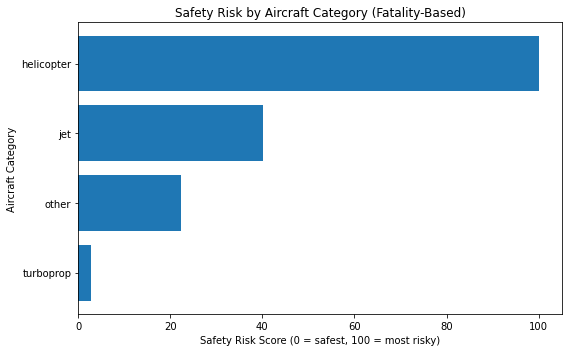


=== Safety Risk by Aircraft Category ===
  aircraft_category  crashes  avg_fatalities_per_crash  fatal_crash_rate  \
0        helicopter        2                  3.000000          1.000000   
1               jet     1140                  2.231579          0.087719   
2             other      840                  1.652381          0.228571   
3         turboprop      518                  1.196911          0.169884   

   category_safety_risk_score  
0                  100.000000  
1                   40.168151  
2                   22.314238  
3                    2.701960  

Saved files:
 - category_safety_risk_barchart.png
 - safety_risk_by_category.csv

Current working folder: c:\Users\Ivy\Documents\Flatiron\Phase1\Project


In [15]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


FILEPATH = r"flight.csv"




# -------------------------
# 1) Load + minimal preparation
# -------------------------
def prepare_flight_data(filepath: str) -> pd.DataFrame:
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")

    df = pd.read_csv(filepath)

    # Drop junk index columns
    df = df.drop(
        columns=[c for c in ["Unnamed: 0", "unnamed: 0", "index"] if c in df.columns],
        errors="ignore"
    )

    # Standardize column names
    df.columns = df.columns.str.lower().str.strip()

    # Rename acc.date if present
    if "acc.date" in df.columns:
        df = df.rename(columns={"acc.date": "acc_date"})

    # Required columns
    required = {"type", "fat"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required column(s): {sorted(missing)}")

    # Clean fatalities
    df["fat"] = pd.to_numeric(df["fat"], errors="coerce").fillna(0)
    df.loc[df["fat"] < 0, "fat"] = 0
    df["fat"] = df["fat"].astype(int)

    # Clean aircraft type
    df["type"] = df["type"].astype(str).str.lower().str.strip()
    df["type"] = df["type"].replace({"nan": "unknown", "": "unknown"})

    return df


# -------------------------
# 2) Aircraft category rules
# -------------------------
def categorize_aircraft(ac_type: str) -> str:
    t = ac_type.lower()

    turboprop_kw = [
        "atr", "dash", "q400", "jetstream", "king air",
        "caravan", "dornier", "beechcraft"
    ]
    jet_kw = [
        "boeing", "airbus", "embraer", "bombardier",
        "gulfstream", "learjet", "citation", "tu-", "il-"
    ]
    heli_kw = [
        "helicopter", "bell", "sikorsky", "ec-", "mi-", "airbus h"
    ]

    if any(k in t for k in heli_kw):
        return "helicopter"
    if any(k in t for k in turboprop_kw):
        return "turboprop"
    if any(k in t for k in jet_kw):
        return "jet"
    return "other"


# -------------------------
# 3) Safety Risk by Category
# -------------------------
def safety_risk_by_category(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["aircraft_category"] = df["type"].apply(categorize_aircraft)

    out = (
        df.groupby("aircraft_category")
          .agg(
              crashes=("aircraft_category", "count"),
              total_fatalities=("fat", "sum"),
              avg_fatalities_per_crash=("fat", "mean"),
              fatal_crash_rate=("fat", lambda x: (x > 0).mean()),
              max_fatalities=("fat", "max"),
              p95_fatalities=("fat", lambda x: x.quantile(0.95)),
          )
          .reset_index()
    )

    # Normalization helper
    def minmax(s: pd.Series) -> pd.Series:
        if s.max() == s.min():
            return pd.Series([0.0] * len(s), index=s.index)
        return (s - s.min()) / (s.max() - s.min())

    out["avg_fat_norm"] = minmax(out["avg_fatalities_per_crash"])
    out["fatal_rate_norm"] = minmax(out["fatal_crash_rate"])

    # Category Safety Risk Score (0 safest → 100 riskiest)
    out["category_safety_risk_score"] = (
        0.7 * out["avg_fat_norm"] +
        0.3 * out["fatal_rate_norm"]
    ) * 100

    out = out.drop(columns=["avg_fat_norm", "fatal_rate_norm"])
    out = out.sort_values("category_safety_risk_score", ascending=False)

    return out


# -------------------------
# 4) Run analysis
# -------------------------
df_clean = prepare_flight_data(FILEPATH)

category_risk = safety_risk_by_category(df_clean)


# -------------------------
# 5) Bar chart + save outputs
# -------------------------
plt.figure(figsize=(8, 5))
plt.barh(
    category_risk["aircraft_category"],
    category_risk["category_safety_risk_score"]
)
plt.xlabel("Safety Risk Score (0 = safest, 100 = most risky)")
plt.ylabel("Aircraft Category")
plt.title("Safety Risk by Aircraft Category (Fatality-Based)")
plt.gca().invert_yaxis()
plt.tight_layout()

# Save chart
plt.savefig("category_safety_risk_barchart.png", dpi=200)
plt.show()

# Print preview table
print("\n=== Safety Risk by Aircraft Category ===")
print(
    category_risk[
        ["aircraft_category", "crashes", "avg_fatalities_per_crash",
         "fatal_crash_rate", "category_safety_risk_score"]
    ]
)

# Save CSV for dashboard use
category_risk.to_csv("safety_risk_by_category.csv", index=False)

print("\nSaved files:")
print(" - category_safety_risk_barchart.png")
print(" - safety_risk_by_category.csv")
print("\nCurrent working folder:", os.getcwd())


*1.4.2 Purchase Risk Analysis (Financial / Asset Risk)*
-------
We cannot change an aircrafts DNA. An aircraft can be safe for people but very expensive to repair or replace. Purchase risk was assessed by analyzing damage severity and total loss rates across aircraft types to estimate the financial exposure associated with aircraft ownership.
Purchase Risk Score =
70% × Average Damage Severity
+ 30% × Total Loss Rate

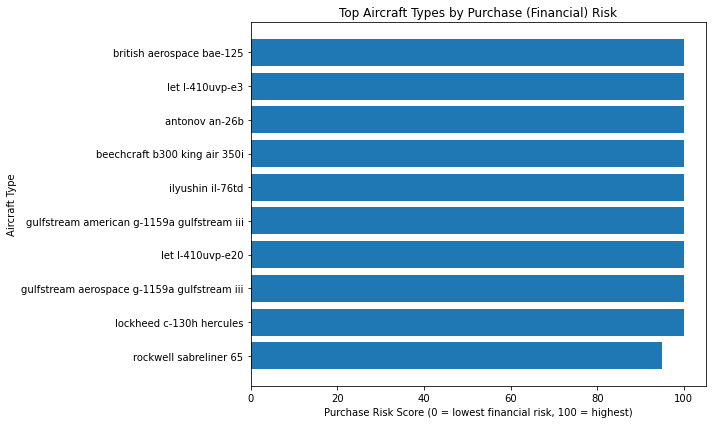


=== Top Aircraft Types by Purchase Risk (Preview) ===
                                            type  crashes  \
257                    british aerospace bae-125        8   
474                              let l-410uvp-e3        6   
55                                antonov an-26b        8   
101                beechcraft b300 king air 350i       12   
447                             ilyushin il-76td        8   
414   gulfstream american g-1159a gulfstream iii        6   
473                             let l-410uvp-e20        6   
411  gulfstream aerospace g-1159a gulfstream iii        8   
478                     lockheed c-130h hercules        6   
501                       rockwell sabreliner 65       12   

     avg_damage_severity  total_loss_rate  purchase_risk_score  
257                  3.0         1.000000                100.0  
474                  3.0         1.000000                100.0  
55                   3.0         1.000000                100.0  
101          

In [16]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# -------------------------
# 0) SET YOUR FILE PATH
# -------------------------
FILEPATH = r"flight.csv"   # change if needed


# -------------------------
# 1) Load + minimal preparation
# -------------------------
def prepare_flight_data(filepath: str) -> pd.DataFrame:
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")

    df = pd.read_csv(filepath)

    # Drop junk index columns
    df = df.drop(
        columns=[c for c in ["Unnamed: 0", "unnamed: 0", "index"] if c in df.columns],
        errors="ignore"
    )

    # Standardize column names
    df.columns = df.columns.str.lower().str.strip()

    # Required columns
    required = {"type", "dmg"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required column(s): {sorted(missing)}")

    # Clean aircraft type
    df["type"] = df["type"].astype(str).str.lower().str.strip()

    # Clean damage codes
    df["dmg"] = df["dmg"].astype(str).str.lower().str.strip()

    # Encode damage severity
    dmg_map = {
        "minor": 1,
        "sub": 2,
        "w/o": 3,
        "written off": 3,
        "written-off": 3,
        "destroyed": 3
    }

    df["dmg_score"] = df["dmg"].map(dmg_map)

    return df


# -------------------------
# 2) Purchase Risk by Type
# -------------------------
def purchase_risk_by_type(df: pd.DataFrame, min_crashes: int = 5) -> pd.DataFrame:
    out = (
        df.groupby("type")
          .agg(
              crashes=("type", "count"),
              avg_damage_severity=("dmg_score", "mean"),
              total_loss_rate=("dmg_score", lambda x: (x == 3).mean()),
          )
          .reset_index()
    )

    # Remove aircraft with too few records
    out = out[out["crashes"] >= min_crashes].copy()

    # Normalize helper
    def minmax(s: pd.Series) -> pd.Series:
        if s.max() == s.min():
            return pd.Series([0.0] * len(s), index=s.index)
        return (s - s.min()) / (s.max() - s.min())

    out["damage_norm"] = minmax(out["avg_damage_severity"])
    out["loss_rate_norm"] = minmax(out["total_loss_rate"])

    # Purchase Risk Score (0 low → 100 high)
    out["purchase_risk_score"] = (
        0.7 * out["damage_norm"] +
        0.3 * out["loss_rate_norm"]
    ) * 100

    out = out.drop(columns=["damage_norm", "loss_rate_norm"])
    out = out.sort_values("purchase_risk_score", ascending=False)

    return out


# -------------------------
# 3) Run analysis
# -------------------------
df_clean = prepare_flight_data(FILEPATH)

MIN_CRASHES = 5
TOP_N = 10

purchase_risk = purchase_risk_by_type(df_clean, min_crashes=MIN_CRASHES)

if purchase_risk.empty:
    MIN_CRASHES = 1
    purchase_risk = purchase_risk_by_type(df_clean, min_crashes=MIN_CRASHES)

top_risky_aircraft = purchase_risk.head(TOP_N)


# -------------------------
# 4) Bar chart + save outputs
# -------------------------
plt.figure(figsize=(10, 6))
plt.barh(
    top_risky_aircraft["type"],
    top_risky_aircraft["purchase_risk_score"]
)
plt.xlabel("Purchase Risk Score (0 = lowest financial risk, 100 = highest)")
plt.ylabel("Aircraft Type")
plt.title("Top Aircraft Types by Purchase (Financial) Risk")
plt.gca().invert_yaxis()
plt.tight_layout()

plt.savefig("purchase_risk_barchart.png", dpi=200)
plt.show()

# Print preview table
print("\n=== Top Aircraft Types by Purchase Risk (Preview) ===")
print(
    top_risky_aircraft[
        ["type", "crashes", "avg_damage_severity",
         "total_loss_rate", "purchase_risk_score"]
    ]
)

# Save CSV for dashboard use
purchase_risk.to_csv("purchase_risk_by_type.csv", index=False)

print("\nSaved files:")
print(" - purchase_risk_barchart.png")
print(" - purchase_risk_by_type.csv")
print("\nCurrent working folder:", os.getcwd())


*1.4.3 Geographic Risk Analysis*
-----
Geographic risk focuses on where accidents happen and how location affects outcomes, not on aircraft design or operators. Geographic risk was assessed by evaluating fatality severity and aircraft damage severity across accident locations to identify operationally high-risk regions.

Geographic Risk Score =
50% × Fatality Severity
+ 50% × Damage Severity


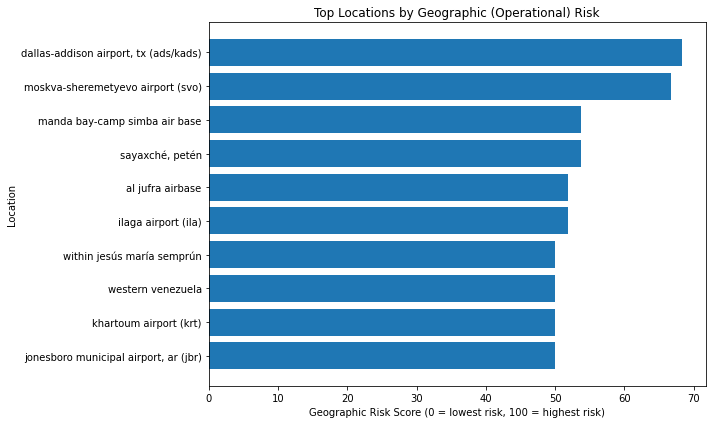


=== Top Locations by Geographic Risk (Preview) ===
                                   location  crashes  \
297   dallas-addison airport, tx (ads/kads)        4   
594       moskva-sheremetyevo airport (svo)        6   
550           manda bay-camp simba air base        4   
932                         sayaxché, petén        4   
158                        al jufra airbase        4   
423                     ilaga airport (ila)        4   
1044             within jesús maría semprún        4   
1035                      western venezuela        4   
478                  khartoum airport (krt)        4   
454   jonesboro municipal airport, ar (jbr)        4   

      avg_fatalities_per_crash  avg_damage_severity  geographic_risk_score  
297                   5.000000             3.000000              68.292683  
594                  13.666667             2.333333              66.666667  
550                   1.000000             3.000000              53.658537  
932                   1

In [17]:
# ==========================================================
# GEOGRAPHIC RISK ANALYSIS by LOCATION + Bar Chart
# ==========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# -------------------------
# 0) SET YOUR FILE PATH
# -------------------------
FILEPATH = r"flight.csv"   # change if needed


# -------------------------
# 1) Load + minimal preparation
# -------------------------
def prepare_flight_data(filepath: str) -> pd.DataFrame:
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")

    df = pd.read_csv(filepath)

    # Drop junk index columns
    df = df.drop(
        columns=[c for c in ["Unnamed: 0", "unnamed: 0", "index"] if c in df.columns],
        errors="ignore"
    )

    # Standardize column names
    df.columns = df.columns.str.lower().str.strip()

    # Required columns
    required = {"location", "fat", "dmg"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required column(s): {sorted(missing)}")

    # Clean fatalities
    df["fat"] = pd.to_numeric(df["fat"], errors="coerce").fillna(0)
    df.loc[df["fat"] < 0, "fat"] = 0
    df["fat"] = df["fat"].astype(int)

    # Clean location text
    df["location"] = df["location"].astype(str).str.lower().str.strip()
    df["location"] = df["location"].replace({"nan": "unknown", "": "unknown"})

    # Clean damage + encode
    df["dmg"] = df["dmg"].astype(str).str.lower().str.strip()
    dmg_map = {
        "minor": 1,
        "sub": 2,
        "w/o": 3,
        "written off": 3,
        "written-off": 3,
        "destroyed": 3
    }
    df["dmg_score"] = df["dmg"].map(dmg_map)

    return df


# -------------------------
# 2) Geographic Risk by Location
# -------------------------
def geographic_risk_by_location(df: pd.DataFrame, min_crashes: int = 3) -> pd.DataFrame:
    out = (
        df.groupby("location")
          .agg(
              crashes=("location", "count"),
              avg_fatalities_per_crash=("fat", "mean"),
              avg_damage_severity=("dmg_score", "mean"),
          )
          .reset_index()
    )

    # Remove locations with very few records
    out = out[out["crashes"] >= min_crashes].copy()

    # Normalization helper
    def minmax(s: pd.Series) -> pd.Series:
        if s.max() == s.min():
            return pd.Series([0.0] * len(s), index=s.index)
        return (s - s.min()) / (s.max() - s.min())

    out["fatal_norm"] = minmax(out["avg_fatalities_per_crash"])
    out["damage_norm"] = minmax(out["avg_damage_severity"])

    # Geographic Risk Score
    out["geographic_risk_score"] = (
        0.5 * out["fatal_norm"] +
        0.5 * out["damage_norm"]
    ) * 100

    out = out.drop(columns=["fatal_norm", "damage_norm"])
    out = out.sort_values("geographic_risk_score", ascending=False)

    return out


# -------------------------
# 3) Run analysis
# -------------------------
df_clean = prepare_flight_data(FILEPATH)

MIN_CRASHES = 3
TOP_N = 10

geo_risk = geographic_risk_by_location(df_clean, min_crashes=MIN_CRASHES)

if geo_risk.empty:
    MIN_CRASHES = 1
    geo_risk = geographic_risk_by_location(df_clean, min_crashes=MIN_CRASHES)

top_risky_locations = geo_risk.head(TOP_N)


# -------------------------
# 4) Bar chart + save outputs
# -------------------------
plt.figure(figsize=(10, 6))
plt.barh(
    top_risky_locations["location"],
    top_risky_locations["geographic_risk_score"]
)
plt.xlabel("Geographic Risk Score (0 = lowest risk, 100 = highest risk)")
plt.ylabel("Location")
plt.title("Top Locations by Geographic (Operational) Risk")
plt.gca().invert_yaxis()
plt.tight_layout()

plt.savefig("geographic_risk_barchart.png", dpi=200)
plt.show()

# Print preview table
print("\n=== Top Locations by Geographic Risk (Preview) ===")
print(
    top_risky_locations[
        ["location", "crashes",
         "avg_fatalities_per_crash",
         "avg_damage_severity",
         "geographic_risk_score"]
    ]
)

# Save CSV for dashboard use
geo_risk.to_csv("geographic_risk_by_location.csv", index=False)

print("\nSaved files:")
print(" - geographic_risk_barchart.png")
print(" - geographic_risk_by_location.csv")
print("\nCurrent working folder:", os.getcwd())
